In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, minimize, minimize_scalar

# Model

Microstrip cavity model from Balanis, for the first mode

In [30]:
def er_eff_min(er, h, W):  # SEE BALANIS
    return (er + 1) / 2 + (er - 1) / 2 * (1 + 12 * h / W) ** (-1 / 2)


def delta_l(er_eff, h, W):
    return h * 0.412 * (er_eff + 0.3) * (W / h + 0.264) / ((er_eff - 0.258) * (W / h + 0.8))


def l_eff(l, er_eff, h, W):
    return delta_l(er_eff, h, W) * 2 + l


def f010(l, h, W, er_eff, c=299792458):
    leff = l_eff(l, er_eff, h, W)
    return c / (2 * leff * np.sqrt(er_eff))

According to 14.2.1 the $\epsilon_r_{eff}$ varies between the minimum one, at low frequency and increases at higher frequencies

In [31]:
def er(delta, er, er_min):
    return er_min + delta * (er - er_min)

The goal here is to estimate delta from the simulations and see how it varies in frequency with respect to dielectric constant and frequency

# Simulation results

In [32]:
#known
h = 0.4e-3
epsilon = np.array([3, 4, 5, 6])
l = np.array([7, 8]) * 1e-3
E, L = np.meshgrid(epsilon, l)

# resonances from matlab postprocessing
freqs = np.array([[11.6207, 10.1696, 9.1650, 8.4061],
                  [10.2432, 8.9649, 8.0819, float("nan")]]) * 1e9

Text(0.5, 1.0, 'resonances [GHz]')

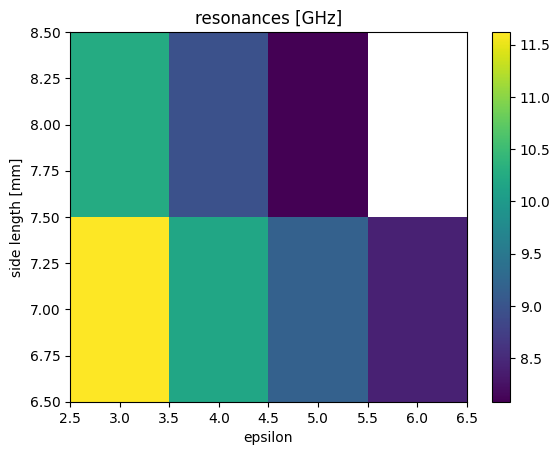

In [33]:
fig, ax = plt.subplots(1)
c = ax.pcolormesh(E, L * 1000, freqs * 1e-9)
ax.set_xlabel('epsilon')
ax.set_ylabel('side length [mm]')
fig.colorbar(c)
ax.set_title('resonances [GHz]')

# Direct inversion

In [34]:
eest = []
for ii in range(len(E.flatten())):
    l = L.flatten()[ii]
    freq = freqs.flatten()[ii]
    invertible = lambda epsilon: f010(l, h, l, er_eff_min(epsilon, h, l)) - freq
    print(fsolve(invertible, 1))
    eest.append(fsolve(invertible, 1))

[3.3181071]
[4.3921239]
[5.45224489]
[6.51717019]
[3.28479152]
[4.34136449]
[5.38136607]
[1.]


In [35]:
eest = np.array(eest).flatten()
eest = np.reshape(eest, E.shape)
eest

# error
error = (E - eest)/E
error

array([[-0.1060357 , -0.09803098, -0.09044898, -0.08619503],
       [-0.09493051, -0.08534112, -0.07627321,  0.83333333]])

Text(0.5, 1.0, '$\\epsilon / \\epsilon_{est}$')

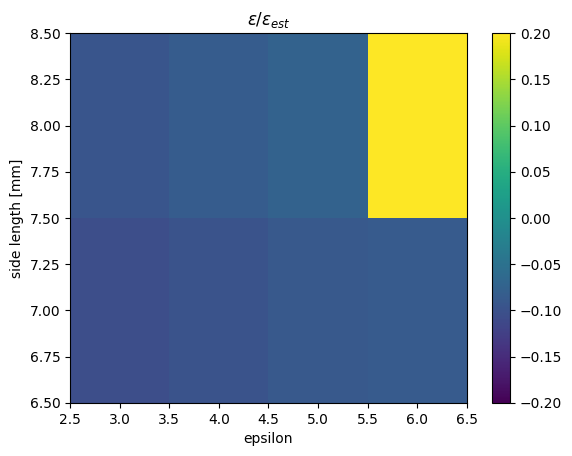

In [36]:
fig, ax = plt.subplots(1)
c = ax.pcolormesh(E, L * 1000, error, vmin=-.2, vmax=.2)
ax.set_xlabel('epsilon')
ax.set_ylabel('side length [mm]')
fig.colorbar(c)
ax.set_title('$\epsilon / \epsilon_{est}$')

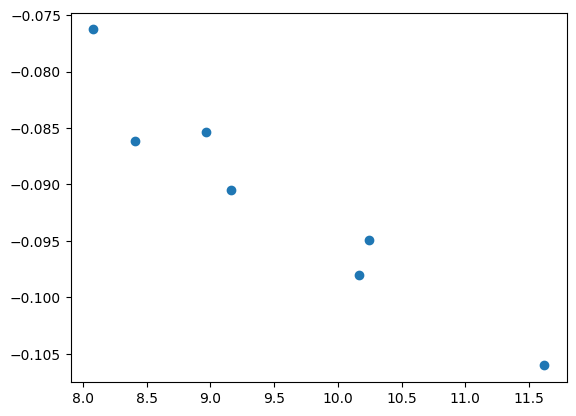

In [37]:
fig, ax = plt.subplots(1)
ax.scatter(freqs.flatten() / 1e9, error.flatten())

# Re-Fitting
find a delta that minimizes the error

In [38]:
E.flatten()

array([3, 4, 5, 6, 3, 4, 5, 6])

In [39]:
def error(delta):
    sq = 0
    for ii in range(len(E.flatten())-1):
        l = L.flatten()[ii]
        e = E.flatten()[ii]
        freq = freqs.flatten()[ii]
        invertible = lambda epsilon: f010(l, h, l, er(delta, epsilon, er_eff_min(epsilon, h, l))) - freq
        epsilon = fsolve(invertible, 1)
        error = (e - epsilon) / e
        sq += error ** 2
    sq /= len(E.flatten())-1
    return sq

In [40]:
res = minimize_scalar(error)

In [41]:
res

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: [ 1.746e-04]
       x: [ 9.622e-01]
     nit: 15
    nfev: 18

# Refined Inversion
use the optimized delta value (to be used in measurements too)


In [42]:
delta = 0.9622
eest = []
for ii in range(len(E.flatten())):
    l = L.flatten()[ii]
    freq = freqs.flatten()[ii]
    invertible = lambda epsilon: f010(l, h, l, er(delta, epsilon, er_eff_min(epsilon, h, l))) - freq
    print(fsolve(invertible, 1))
    eest.append(fsolve(invertible, 1))

[3.06071568]
[4.01547884]
[4.95788911]
[5.90457025]
[3.05366781]
[4.00336054]
[4.9381582]
[1.]


In [43]:
eest = np.array(eest).flatten()
eest = np.reshape(eest, E.shape)
eest

# error
error = (E - eest)/E
error

array([[-0.02023856, -0.00386971,  0.00842218,  0.01590496],
       [-0.01788927, -0.00084014,  0.01236836,  0.83333333]])

Text(0.5, 1.0, '$\\epsilon / \\epsilon_{est}$')

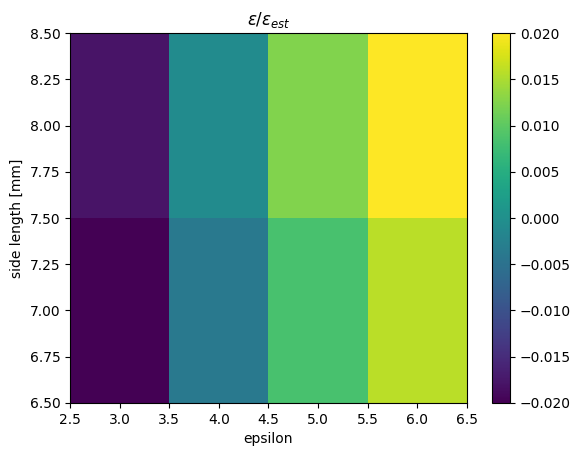

In [44]:
fig, ax = plt.subplots(1)
c = ax.pcolormesh(E, L * 1000, error, vmin=-.02, vmax=.02)
ax.set_xlabel('epsilon')
ax.set_ylabel('side length [mm]')
fig.colorbar(c)
ax.set_title('$\epsilon / \epsilon_{est}$')

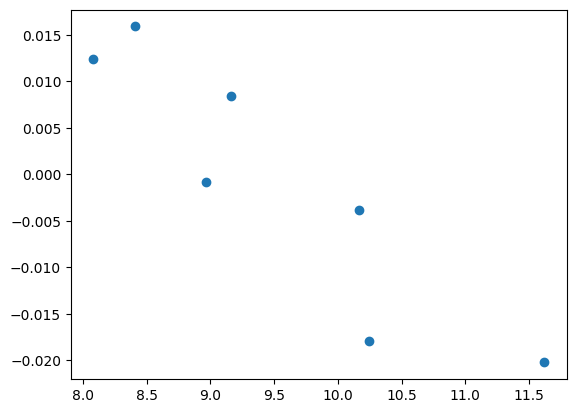

In [45]:
fig, ax = plt.subplots(1)
ax.scatter(freqs.flatten() / 1e9, error.flatten())

# Sensitivity analysis
based on the corrected microstrip model

substrate height

In [46]:
# +- 50um variation of height
h2 = h + 50e-6
h1 = h - 50e-6
delta_h = 100e-6

# resulting epsilon
eest2 = []
for ii in range(len(E.flatten())-1):
    l = L.flatten()[ii]
    freq = freqs.flatten()[ii]
    invertible = lambda epsilon: f010(l, h2, l, er(delta, epsilon, er_eff_min(epsilon, h2, l))) - freq
    #print(fsolve(invertible, 1))
    eest2.append(fsolve(invertible, 1))

eest2 = np.array(eest2).flatten()

eest1 = []
for ii in range(len(E.flatten())-1):
    l = L.flatten()[ii]
    freq = freqs.flatten()[ii]
    invertible = lambda epsilon: f010(l, h1, l, er(delta, epsilon, er_eff_min(epsilon, h1, l))) - freq
    #print(fsolve(invertible, 1))
    eest1.append(fsolve(invertible, 1))
eest1 = np.array(eest1).flatten()
# delta epsilon
delta_e = eest2 - eest1

Sh = delta_e / delta_h
print(Sh, ' per m')
print('to maintain this error below 1% the height has to be known with an accuracy of ', np.abs(1/(100*Sh)*1e6), 'um')

[ -773.35129637  -965.27695093 -1156.1913547  -1348.6899082
  -682.02235432  -850.80854023 -1018.20606279]  per m
to maintain this error below 1% the height has to be known with an accuracy of  [12.93073413 10.3597211   8.64908733  7.41460282 14.662276   11.75352565
  9.82119471] um


patch length

In [52]:
# +- 100um variation of Length
L2 = L + 50e-6
L1 = L - 50e-6
delta_le = 100e-6
print(L2)

# resulting epsilon
eest2 = []
for ii in range(len(E.flatten())-1):
    l = L2.flatten()[ii]
    freq = freqs.flatten()[ii]
    invertible = lambda epsilon: f010(l, h, l, er(delta, epsilon, er_eff_min(epsilon, h, l))) - freq
    #print(invertible)
    #print(fsolve(invertible, 5))
    eest2.append(fsolve(invertible, 5))

eest2 = np.array(eest2).flatten()

eest1 = []
for ii in range(len(E.flatten())-1):
    l = L1.flatten()[ii]
    freq = freqs.flatten()[ii]
    invertible = lambda epsilon: f010(l, h, l, er(delta, epsilon, er_eff_min(epsilon, h, l))) - freq
    #print(fsolve(invertible, 1))
    eest1.append(fsolve(invertible, 1))
eest1 = np.array(eest1).flatten()

# delta epsilon
delta_e = eest2 - eest1

Sl = delta_e / delta_le
print(Sl, ' per m')
print('to maintain this error below 1% the length has to be known with an accuracy of ', np.abs(1/(100*Sl)*1e6), 'um')

[[0.00705 0.00705 0.00705 0.00705]
 [0.00805 0.00805 0.00805 0.00805]]
[ -848.50530013 -1109.58841744 -1367.52474962 -1626.74089756
  -743.38728213  -971.80258814 -1196.81245042]  per m
to maintain this error below 1% the length has to be known with an accuracy of  [11.78543021  9.01235074  7.31248192  6.14726046 13.4519385  10.29015576
  8.35552805] um


In [54]:
freqs.flatten()/1e9


array([11.6207, 10.1696,  9.165 ,  8.4061, 10.2432,  8.9649,  8.0819,
           nan])